In [13]:
! pip  install transformers accelerate



### Batch Process Papers

In [15]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import os

# Load FLAN-T5 model and tokenizer
model_id = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id, device_map="auto")

extractor = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Define input and output folders
input_folder = "papers"  # folder with .txt files
output_folder = "abstract_intro"
os.makedirs(output_folder, exist_ok=True)

# Prompt builder
def build_prompt(text):
    return f"""Extract the abstract and introduction from the following scientific paper:\n\n{text}\n\nOnly return the abstract and introduction."""

# Loop through all .txt files
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        path = os.path.join(input_folder, filename)
        with open(path, "r", encoding="utf-8") as f:
            full_text = f.read()

        # Truncate to ~2000 tokens to stay safe with T5 limit
        truncated_text = full_text[:4000]

        prompt = build_prompt(truncated_text)
        result = extractor(prompt, max_new_tokens=512)[0]['generated_text']

        # Save output
        output_path = os.path.join(output_folder, f"{filename.replace('.txt', '')}_intro.txt")
        with open(output_path, "w", encoding="utf-8") as out_f:
            out_f.write(result)

        print(f"✅ Processed: {filename}")


model.safetensors:  17%|#6        | 168M/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (1015 > 512). Running this sequence through the model will result in indexing errors


✅ Processed: A. A. Grib_2008_How to play macroscopic quantum game.txt
✅ Processed: A. A. Zhukov_2018_Quantum communication protocols as a benchmark for.txt
✅ Processed: A. A. Zhukov_2023_Quantum error mitigation in the regime of high noi.txt
✅ Processed: A. Aghamohammadi_1995_On the Classification of quantum qroup stuctures o.txt
✅ Processed: A. B. Sainz_2017_A formalism for steering with local quantum measur.txt
✅ Processed: A. Bermudez_2017_Assessing the progress of trapped-ion processors t.txt
✅ Processed: A. Bermudez_2018_Fault-tolerant protection of near-term trapped-ion.txt
✅ Processed: A. Blaut_1997_The Time Evolution of Quantum Universe in The Quan.txt
✅ Processed: A. Bolt_2016_Foliated Quantum Codes.txt


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Processed: A. Bolt_2018_Decoding Schemes for Foliated Sparse Quantum Error.txt
✅ Processed: A. Chalkiadakis_2023_Exploring Quantum Neural Networks for the Discover.txt
✅ Processed: A. Chiesa_2018_Quantum hardware simulating four-dimensional inela.txt
✅ Processed: A. D. Córcoles_2014_Detecting arbitrary quantum errors via stabilizer .txt
✅ Processed: A. Ekert_1996_Error Correction in Quantum Communication.txt
✅ Processed: A. Ekert_1999_Against Quantum Noise.txt
✅ Processed: A. J. Scott_2003_Multipartite entanglement, quantum-error-correctin.txt
✅ Processed: A. J. Scott_2004_Probabilities of failure for quantum error correct.txt
✅ Processed: A. K. Aiston_1997_A skein theoretic proof of the hook formula for qu.txt
✅ Processed: A. M. Steane_2003_Quantum Computing and Error Correction.txt
✅ Processed: A. M. Stephens_2006_Gate-level simulation of logical state preparation.txt
✅ Processed: A. M. Stephens_2007_Universal fault tolerant quantum computation on bi.txt
✅ Processed: A. Myerson_20

### Pipeline: Embed + Store

In [16]:
! pip install sentence-transformers numpy tqdm


In [17]:
import os
import numpy as np
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# === 1. Config ===
input_folder = "abstract_intro"   # folder with cleaned .txt files
embedding_file = "embeddings_abstract_intro.npz"  # output file

# === 2. Optional Cleaning Function ===
def clean_text(text):
    text = re.sub(r'\[\d+(?:[-,]\d+)*\]', '', text)  # Remove citations like [1], [2-4]
    text = re.sub(r'\b\d+\b', '', text)              # Remove standalone digits
    text = re.sub(r'\s+', ' ', text).strip()         # Remove excess whitespace
    return text

# === 3. Load Sentence-BERT ===
model = SentenceTransformer("all-MiniLM-L6-v2")  # good general-purpose model

# === 4. Process All Files ===
embeddings = []
filenames = []

print("🔁 Generating embeddings for all documents...")
for fname in tqdm(os.listdir(input_folder)):
    if fname.endswith(".txt"):
        path = os.path.join(input_folder, fname)
        with open(path, "r", encoding="utf-8") as f:
            text = f.read()
            cleaned = clean_text(text)
            emb = model.encode(cleaned)  # returns 384-dim vector
            embeddings.append(emb)
            filenames.append(fname)

# === 5. Save to .npz file ===
np.savez(embedding_file, embeddings=np.array(embeddings), filenames=np.array(filenames))

print(f"\n✅ Done. Saved {len(embeddings)} embeddings to {embedding_file}")



🔁 Generating embeddings for all documents...


100%|██████████| 2981/2981 [00:54<00:00, 54.89it/s]


✅ Done. Saved 2981 embeddings to embeddings_abstract_intro.npz


### Clustering Code

In [18]:
! pip install umap-learn hdbscan matplotlib pandas


   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 726.2/726.2 kB 9.9 MB/s eta 0:00:00


c:\Users\learn\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Saved clustering results to clustered_papers.csv


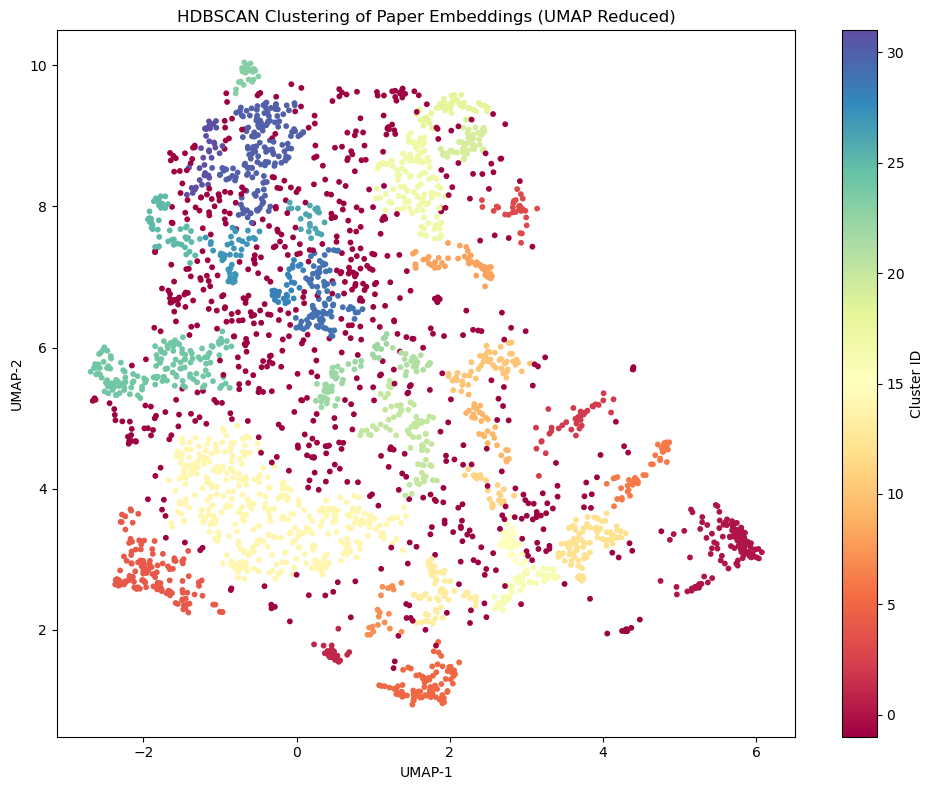

In [19]:
import numpy as np
import pandas as pd
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# === 1. Load Embeddings ===
data = np.load("embeddings_abstract_intro.npz")
X = data["embeddings"]
filenames = data["filenames"]

# === 2. Optional: Scale Embeddings ===
X_scaled = StandardScaler().fit_transform(X)

# === 3. Reduce Dimensionality (UMAP) ===
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# === 4. Run Clustering (HDBSCAN) ===
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5, metric='euclidean')
labels = clusterer.fit_predict(X_umap)

# === 5. Save Clustered Data ===
df = pd.DataFrame({
    "filename": filenames,
    "cluster": labels,
    "x": X_umap[:, 0],
    "y": X_umap[:, 1]
})
df.to_csv("clustered_papers.csv", index=False)
print(f"✅ Saved clustering results to clustered_papers.csv")

# === 6. Optional Visualization ===
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='Spectral', s=10)
plt.title("HDBSCAN Clustering of Paper Embeddings (UMAP Reduced)")
plt.colorbar(label="Cluster ID")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("clusters_plot.png", dpi=300)
plt.show()


 
<div style="background-color: #d4edda; padding: 10px; border-radius: 5px; border: 1px solid #c3e6cb;">
    <h2 style="color: #155724;">🎉 You have reached the end of the notebook! 🏁</h2>
    <p style="color: #155724;">Congratulations on completing your workflow. Feel free to review the results and make any necessary adjustments. Great job!</p>
</div>
 